<center>
<a href="http://uf-mi.u-bordeaux.fr/MSS/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/logo_MAS_MSS.jpg" style="float:left; max-width: 400px; display: inline" alt="MSS"/></a> 

<a href="https://www.math.u-bordeaux.fr/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/LogoIMB.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 200px; display: inline" alt="Python"/></a> UE M2 Master IOD Transport optimal

# Projet : Transfert de couleur par transport optimal

## Présentation du projet

L'objectif de ce projet est de proposer deux algorithmes basés sur le transport optimal pour réaliser le transfert de couleurs entre 2 images :

- la première méthode considèrera une approche par un algorithme stochastique pour le transport optimal régularisé, et vous devrez illustrer l'intérêt computationnel de cette approche par rapport à l'utilisation de l'algorithme de Sinkhorn - Partie 1 du projet.

- la deuxième méthode considèrera une approximation du transport entre nuages de points (où les points sont les pixels dans l'espace RGB) avec la méthode dite du "sliced optimal transport"  - Partie 2 du projet.

On rappelle tout d'abord quelques principes du transfert de couleurs entre deux images à partir du transport optimal. Les pixels de chaque image sont considérés comme des mesures de diracs dans l'espace de couleurs RGB. Les distributions des couleurs de deux images avec $n$ et $m$ pixels respectivement, s'écrivent ainsi comme les mesures discrètes :
$$
\alpha=\sum_{i=1}^n \frac1n \delta_{X_i} \quad \mbox{et} \quad \beta=\sum_{j=1}^m \frac1n \delta_{Y_j},
$$
où $X_i \in \mathbb{R}^3$ est le code couleur du pixel $i$ de la première image, et $Y_j \in \mathbb{R}^3$ est le code couleur du pixel $j$ de la première image. Dans la suite, on identifira le pixel $i$ (resp. pixel $j$) et son code couleur $X_i$ (resp. $Y_j$) dans les notations.

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import os, ot, imageio, matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as sd
from time import time
from skimage.transform import resize
from tqdm import tqdm
import IPython.display as dp

In [2]:
# Lecture de deux images
path= 'im/'
imrgb1 = plt.imread(path+'renoir.jpg')/255
imrgb2 = plt.imread(path+'gauguin.jpg')/255

In [3]:
# Fonction pour tracer les pixels dans l'espace colorimétrique RVB
def plot_pixel_3D(im,fig0,i,ni,nj):
    Z=im.reshape([im.shape[0]*im.shape[1],3])
    nb = 3000
    r = np.random.RandomState(42)
    idZ = r.randint(Z.shape[0], size=(nb,))
    Zs = Z[idZ, :]
    axis = fig0.add_subplot(ni, nj, i, projection="3d")
    axis.scatter(Zs[:, 0], Zs[:,1],Zs[:, 2], c=Zs,s=100)
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue")

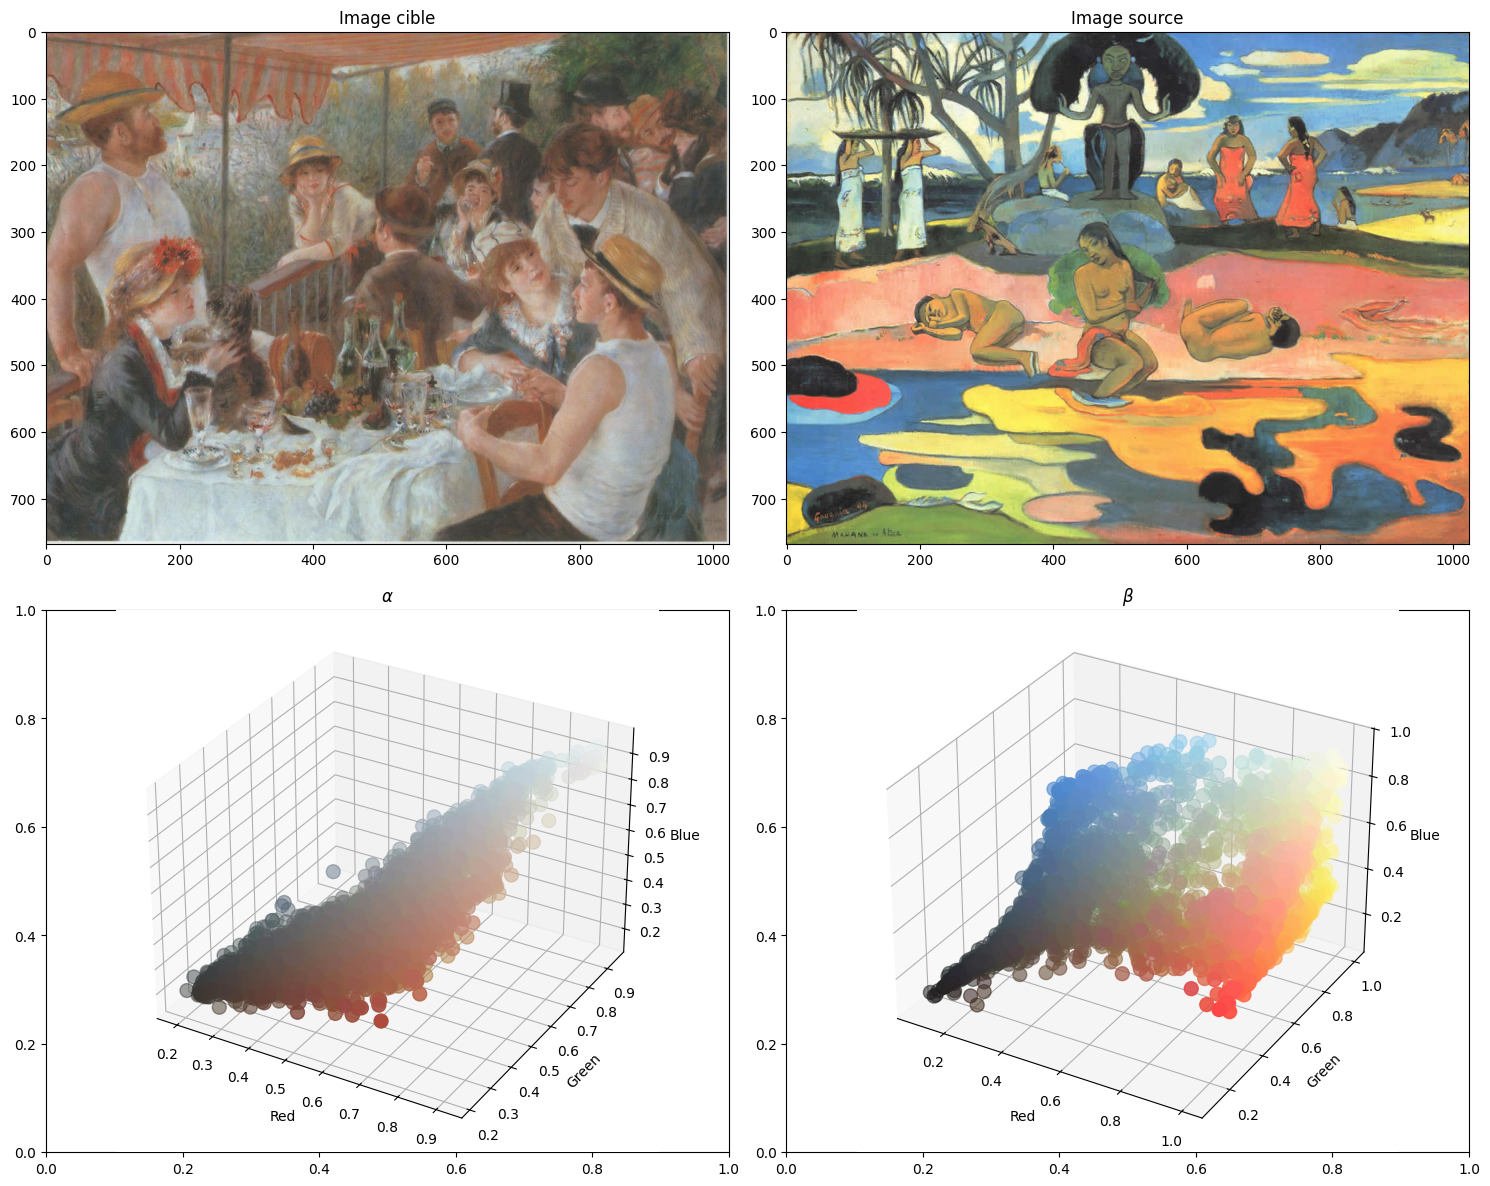

In [4]:
# Afficher les images et leurs histogrammes de couleurs
fig, axes = plt.subplots(2,2, figsize=(15, 12))

axes[0][0].imshow(imrgb1)
axes[0][1].imshow(imrgb2)

axes[0][0].set_title('Image cible')
axes[0][1].set_title('Image source')

plot_pixel_3D(imrgb1,fig,3,2,2)
plot_pixel_3D(imrgb2,fig,4,2,2)
axes[1][0].set_title(r'$\alpha$')
axes[1][1].set_title(r'$\beta$')

plt.tight_layout()

Le transfert des couleurs peut prendre beaucoup de temps si vous utilisez des images en pleine résolution. A des fins d'expérimentation, il est donc conseillé de sous-échantillonner les deux images par un facteur $s$ suffisamment grand. Cette étape réduire le nombre de données dans les nuages de points de couleur à transporter.

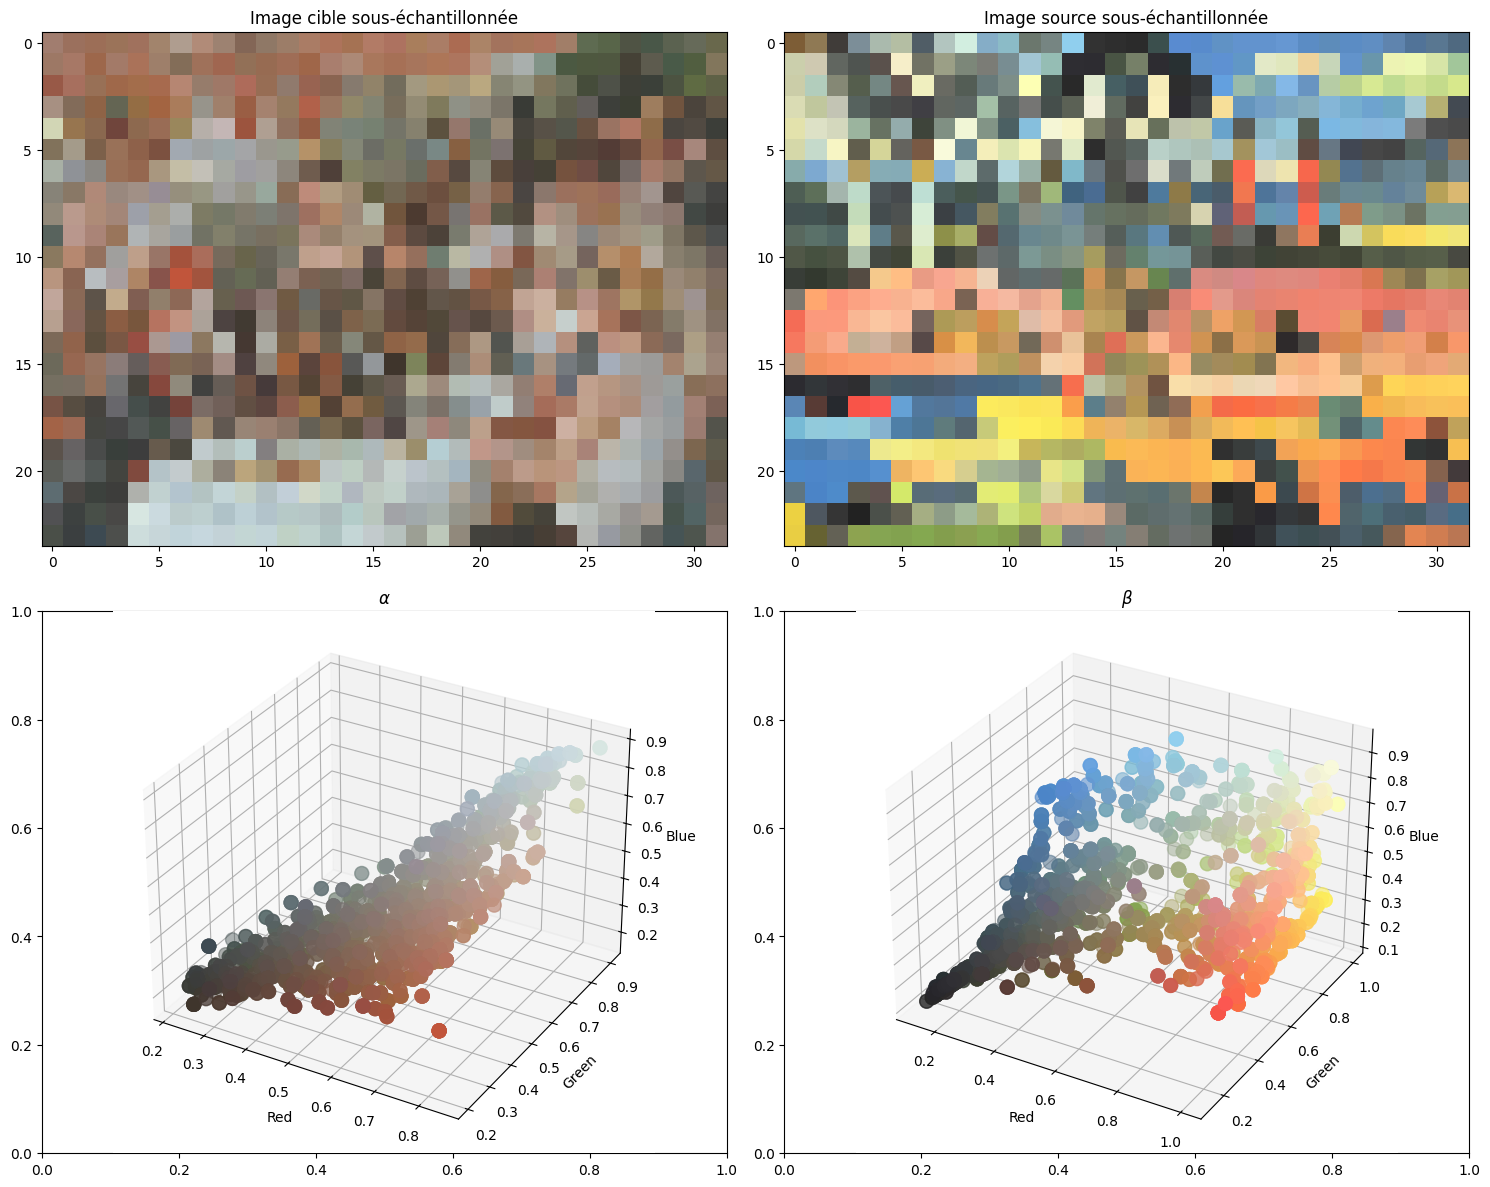

In [6]:
s = 32   # Paramètre de réduction de dimension des images

im1_subsample = imrgb1[1::s,1::s,0:3]
im2_subsample = imrgb2[1::s,1::s,0:3]

fig, axes = plt.subplots(2,2, figsize=(15, 12))

axes[0][0].imshow(im1_subsample)
axes[0][1].imshow(im2_subsample)

axes[0][0].set_title('Image cible sous-échantillonnée')
axes[0][1].set_title('Image source sous-échantillonnée')


plot_pixel_3D(im1_subsample,fig,3,2,2)
plot_pixel_3D(im2_subsample,fig,4,2,2)

axes[1][0].set_title(r'$\alpha$')
axes[1][1].set_title(r'$\beta$')

plt.tight_layout()

## Travail à réaliser - Partie 1

- Pour un facteur de réduction de dimension $s$ donné (commencer avec $s=32$), vous devez impléter le transfert de couleur entre les deux images sous-échantillonnées à l'aide d'un algorithme stochastique pour le transport régularisé.

- Vous devrez ensuite comparer les résultats obtenus avec ceux basés sur l'algorithme de Sinkhorn en terme de temps de convergence des algorithmes pour avoir une qualité de transfert de couleur similaire.

- Si on diminue le facteur de réduction de dimension $s$, quelle est la méthode qui donne le plus rapidement un résultat visual satisfaisant dans le transfert de couleur ?

### **Algorithme Stochastique**

In [9]:
X = im1_subsample.reshape((im1_subsample.shape[0] * im1_subsample.shape[1], 3))
Y = im2_subsample.reshape((im2_subsample.shape[0] * im2_subsample.shape[1], 3))

n = X.shape[0]
m = Y.shape[0]

a = np.ones((n,)) / n  
b = np.ones((m,)) / m  

In [10]:
def cost_matrix(X, Y):
    """ Calcule la matrice des coûts entre tous les points de X et Y """
    return (np.sum(X**2, axis=1).reshape(n, 1) @ np.ones((1, m)) + np.ones((n, 1)) @ np.sum(Y**2, axis=1).T.reshape(1, m) -2 * X @ Y.T)

def cost_single(x, Y):
    """ Calcule le coût entre un point x et tous les points de Y """
    return np.sum(x**2) + np.sum(Y**2, axis=1) - 2 * (Y @ x)

def c_transform(g, x, Y):
    """ Effectue le c-transform pour un point x donné """
    cost_x = cost_single(x, Y)
    return np.min(cost_x - g)
    
def h0(g, x, Y, b):
    """ Calcule la fonction h_0(g) pour un point x donné """
    return c_transform(g, x, Y) + np.dot(g, b)

def grad_h0(g, x, Y, b):
    """ Calcule le gradient de h_0(g) pour un point x donné """
    cost_x = cost_single(x, Y)
    j_star = np.argmin(cost_x - g)
    grad = b.copy()
    grad[j_star] = grad[j_star] - 1
    return grad

In [11]:
def Algo_Sto(X, Y, a, b, c=1, rho=1, n_iter=10000, verbose = True):   

    """ Algorithme stochastique pour estimer le coût de transport optimal entre deux distributions """
    
    # Stockage de l'estimateur récursif de la valeur du coût de transport optimal
    hat_L_storage = np.zeros(n_iter)
   
    # Tirage des indices X_n selon la distribution alpha
    sample = np.random.choice(a=np.arange(n), size=n_iter, p=a)
    
    # Initialisation du vecteur dual g
    g = np.random.random(m)
    g = g - np.mean(g)
    
    # Première itération pour lancer la boucle
    x = X[sample[0], :]
    hat_L_storage[0] = h0(g, x, Y, b)
    
    # Boucle de l'algorithme stochastique
    for k in tqdm(range(1, n_iter), desc ="Algorithme Stochastique"):
        # Affichage progressif
        if k % 100000 == 0 and verbose:
            print(f"Iteration {k}: Coût estimé = {hat_L_storage[k-1]}")
        
        # Tirage d'une réalisation selon la loi alpha
        x = X[sample[k], :]
    
        # Mise à jour de la valeur de g
        gamma = c * k**(-rho)
        g = g + gamma * grad_h0(g, x, Y, b)
    
        # Estimateur récursif de la valeur du coût de transport optimal
        hat_L_storage[k] = ((k-1)/k) * hat_L_storage[k-1] + h0(g, x, Y, b) / k

        L = [g, hat_L_storage, hat_L_storage[k]]
    return L

In [20]:
n_iter = 10**6
c = 1
rho = 1/2
res_Algo_Sto = Algo_Sto(X, Y, a, b, c=c, rho=rho, n_iter=n_iter)

Algorithme Stochastique:  10%|█         | 101219/999999 [00:13<02:15, 6643.61it/s]

Iteration 100000: Coût estimé = 0.029059269116427797


Algorithme Stochastique:  20%|██        | 200891/999999 [00:28<01:48, 7349.97it/s]

Iteration 200000: Coût estimé = 0.037182647329885014


Algorithme Stochastique:  30%|███       | 300805/999999 [00:45<01:58, 5902.08it/s]

Iteration 300000: Coût estimé = 0.03988837147929335


Algorithme Stochastique:  40%|████      | 401068/999999 [01:00<01:23, 7186.70it/s]

Iteration 400000: Coût estimé = 0.04124808199962521


Algorithme Stochastique:  50%|█████     | 501156/999999 [01:15<01:09, 7143.58it/s]

Iteration 500000: Coût estimé = 0.04211108895527687


Algorithme Stochastique:  60%|██████    | 600807/999999 [01:30<00:53, 7401.62it/s]

Iteration 600000: Coût estimé = 0.04266768928467737


Algorithme Stochastique:  70%|███████   | 700993/999999 [01:45<00:42, 7010.52it/s]

Iteration 700000: Coût estimé = 0.043070347433070345


Algorithme Stochastique:  80%|████████  | 800952/999999 [02:04<00:37, 5316.89it/s]

Iteration 800000: Coût estimé = 0.043353908785133614


Algorithme Stochastique:  90%|█████████ | 901262/999999 [02:19<00:13, 7547.67it/s]

Iteration 900000: Coût estimé = 0.04360310039973373


Algorithme Stochastique: 100%|██████████| 999999/999999 [02:34<00:00, 6485.64it/s]


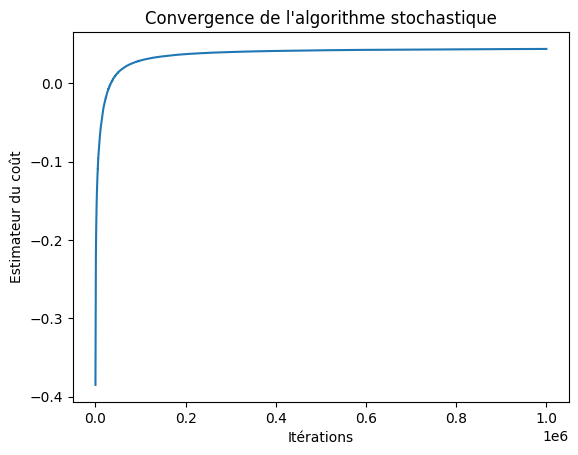

In [21]:
g_last = res_Algo_Sto[0]
L_hat = res_Algo_Sto[1]
plt.plot(L_hat[100:])
plt.xlabel("Itérations")
plt.ylabel("Estimateur du coût")
plt.title("Convergence de l'algorithme stochastique")
plt.show()

In [22]:
def P_stochastic(X, Y, g, a, b):
    """ Matrice de transport basée sur les correspondances de l'algorithme stochastique """
    P_stochastic = np.zeros((n, m))
    for i in tqdm(range(n), desc = "P_stochastic"):
        cost_i = cost_single(X[i], Y)
        j_star = np.argmin(cost_i - g)
        P_stochastic[i, j_star] = a[i]
    return P_stochastic

P_stochastic: 100%|██████████| 768/768 [00:00<00:00, 13687.66it/s]


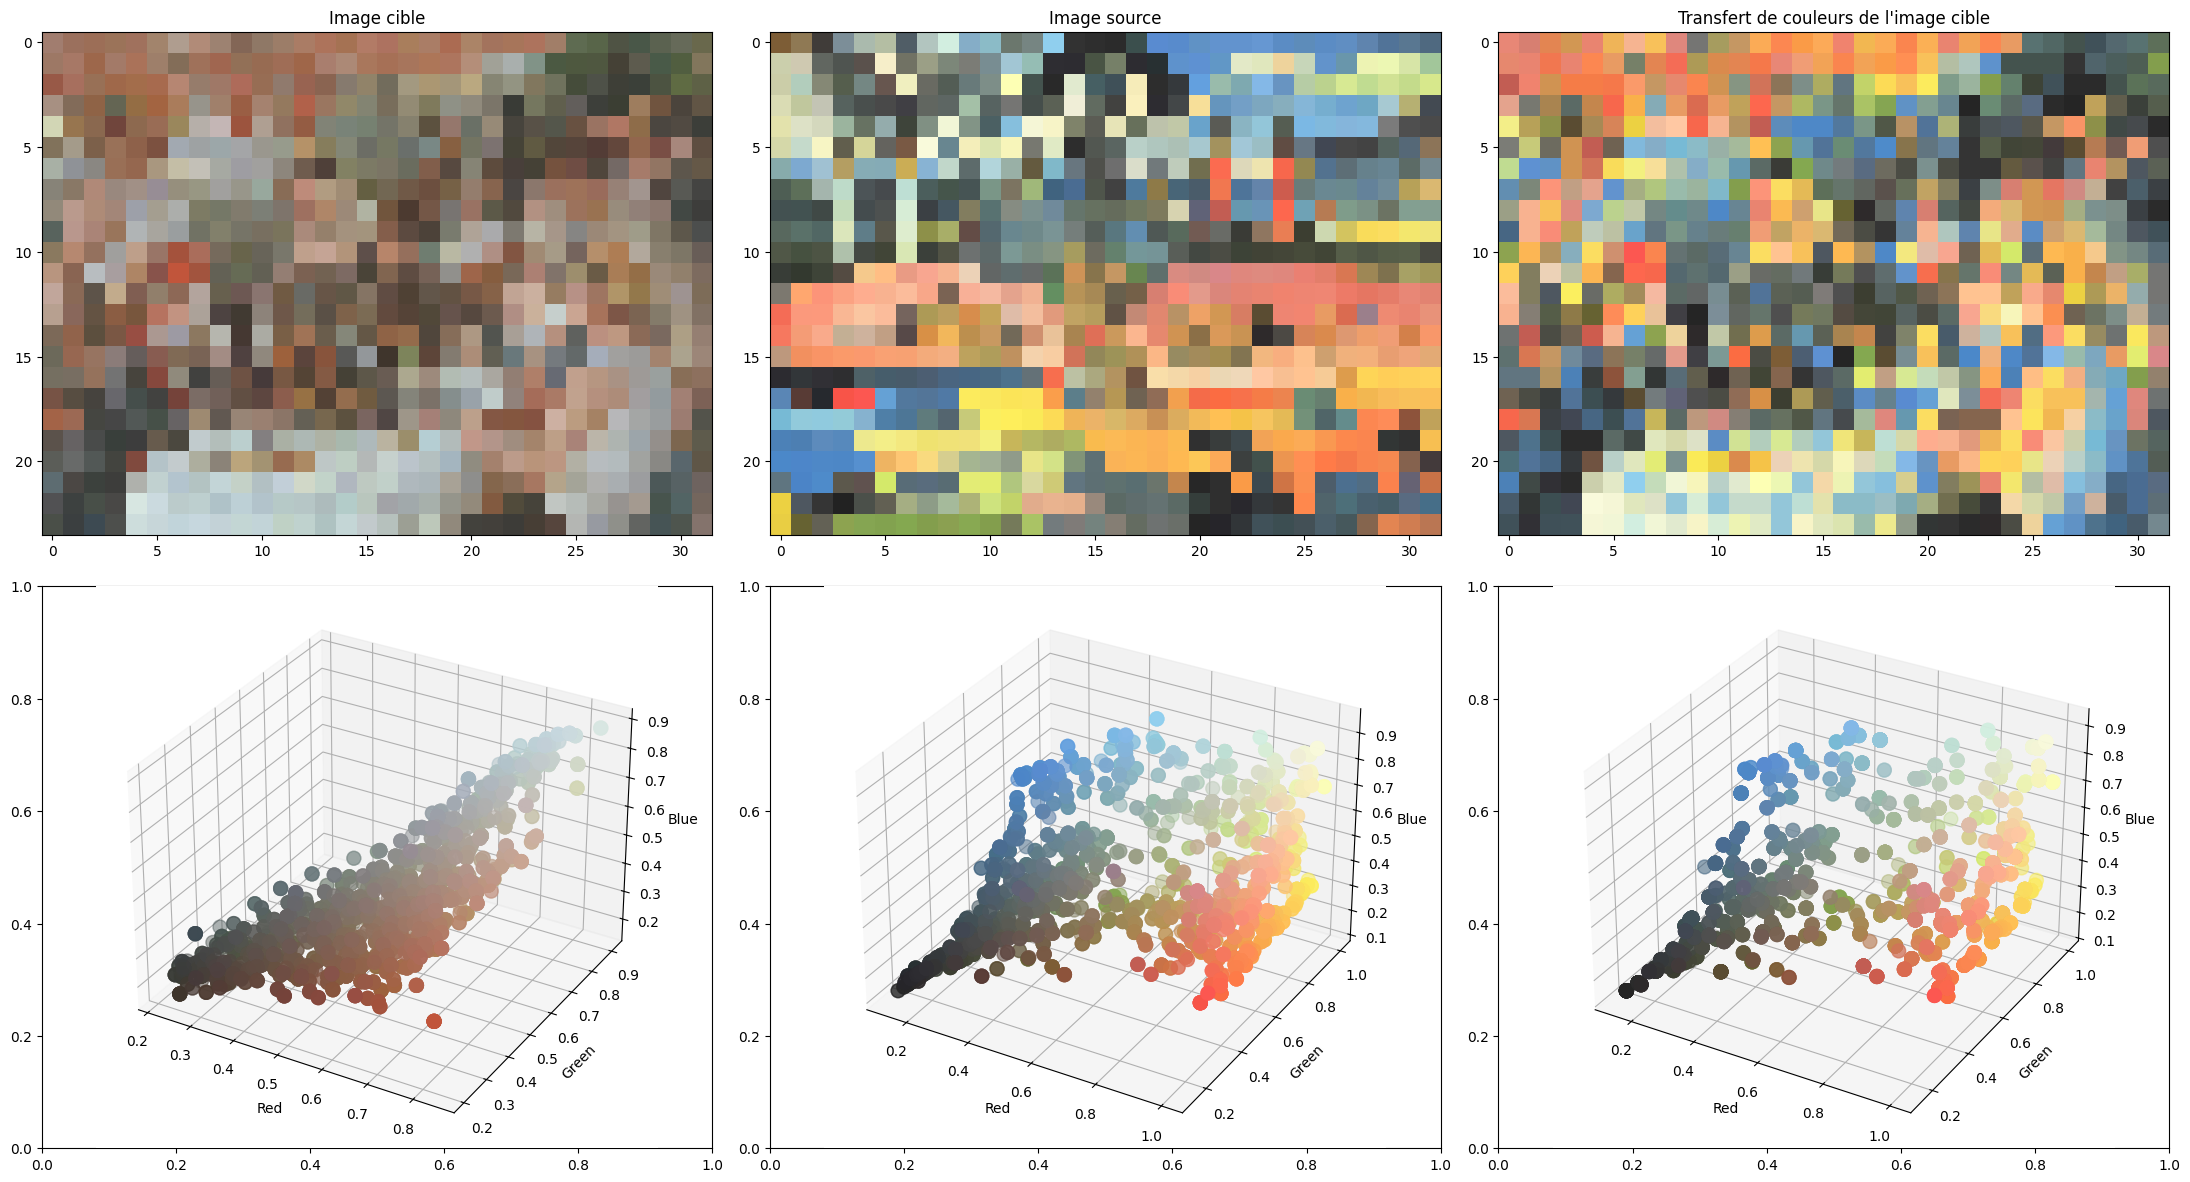

In [23]:
im1_col_trf = Y[np.argmax(P_stochastic(X,Y,g_last,a,b), axis=1)].reshape((im1_subsample.shape))

# Création d'une figure pour afficher les résultats
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# Affichage des images
axes[0][0].set_title('Image cible')
axes[0][0].imshow(im1_subsample)

axes[0][1].set_title('Image source')
axes[0][1].imshow(im2_subsample)

axes[0][2].set_title("Transfert de couleurs de l'image cible")
axes[0][2].imshow(im1_col_trf)

# Tracé des pixels dans l'espace RVB
plot_pixel_3D(im1_subsample, fig, 4, 2, 3)  

plot_pixel_3D(im2_subsample, fig, 5, 2, 3)  

plot_pixel_3D(im1_col_trf, fig, 6, 2, 3)

plt.tight_layout()

### **Algorithme de Sinkhorn**

In [25]:
def sinkhorn(a, b, C, epsilon, niter):
    """ Implémentation de l'algorithme de Sinkhorn pour résoudre le problème de transport optimal entropique """
    
    # Initialisation des vecteurs u et v (vecteurs normalisés)
    u = np.ones((n, 1)) / n
    v = np.ones((m, 1)) / m 
    K = np.exp(-C / epsilon)
    
    # Boucle principale de Sinkhorn
    for k in tqdm(range(niter), desc = "Algorithme de Sinkhorn"):
        u = a / (K @ v)
        v = b / (K.T @ u)

    P = np.diag(u[:, 0]) @ K @ np.diag(v[:, 0])
    return P

Algorithme de Sinkhorn: 100%|██████████| 100/100 [00:11<00:00,  8.83it/s]


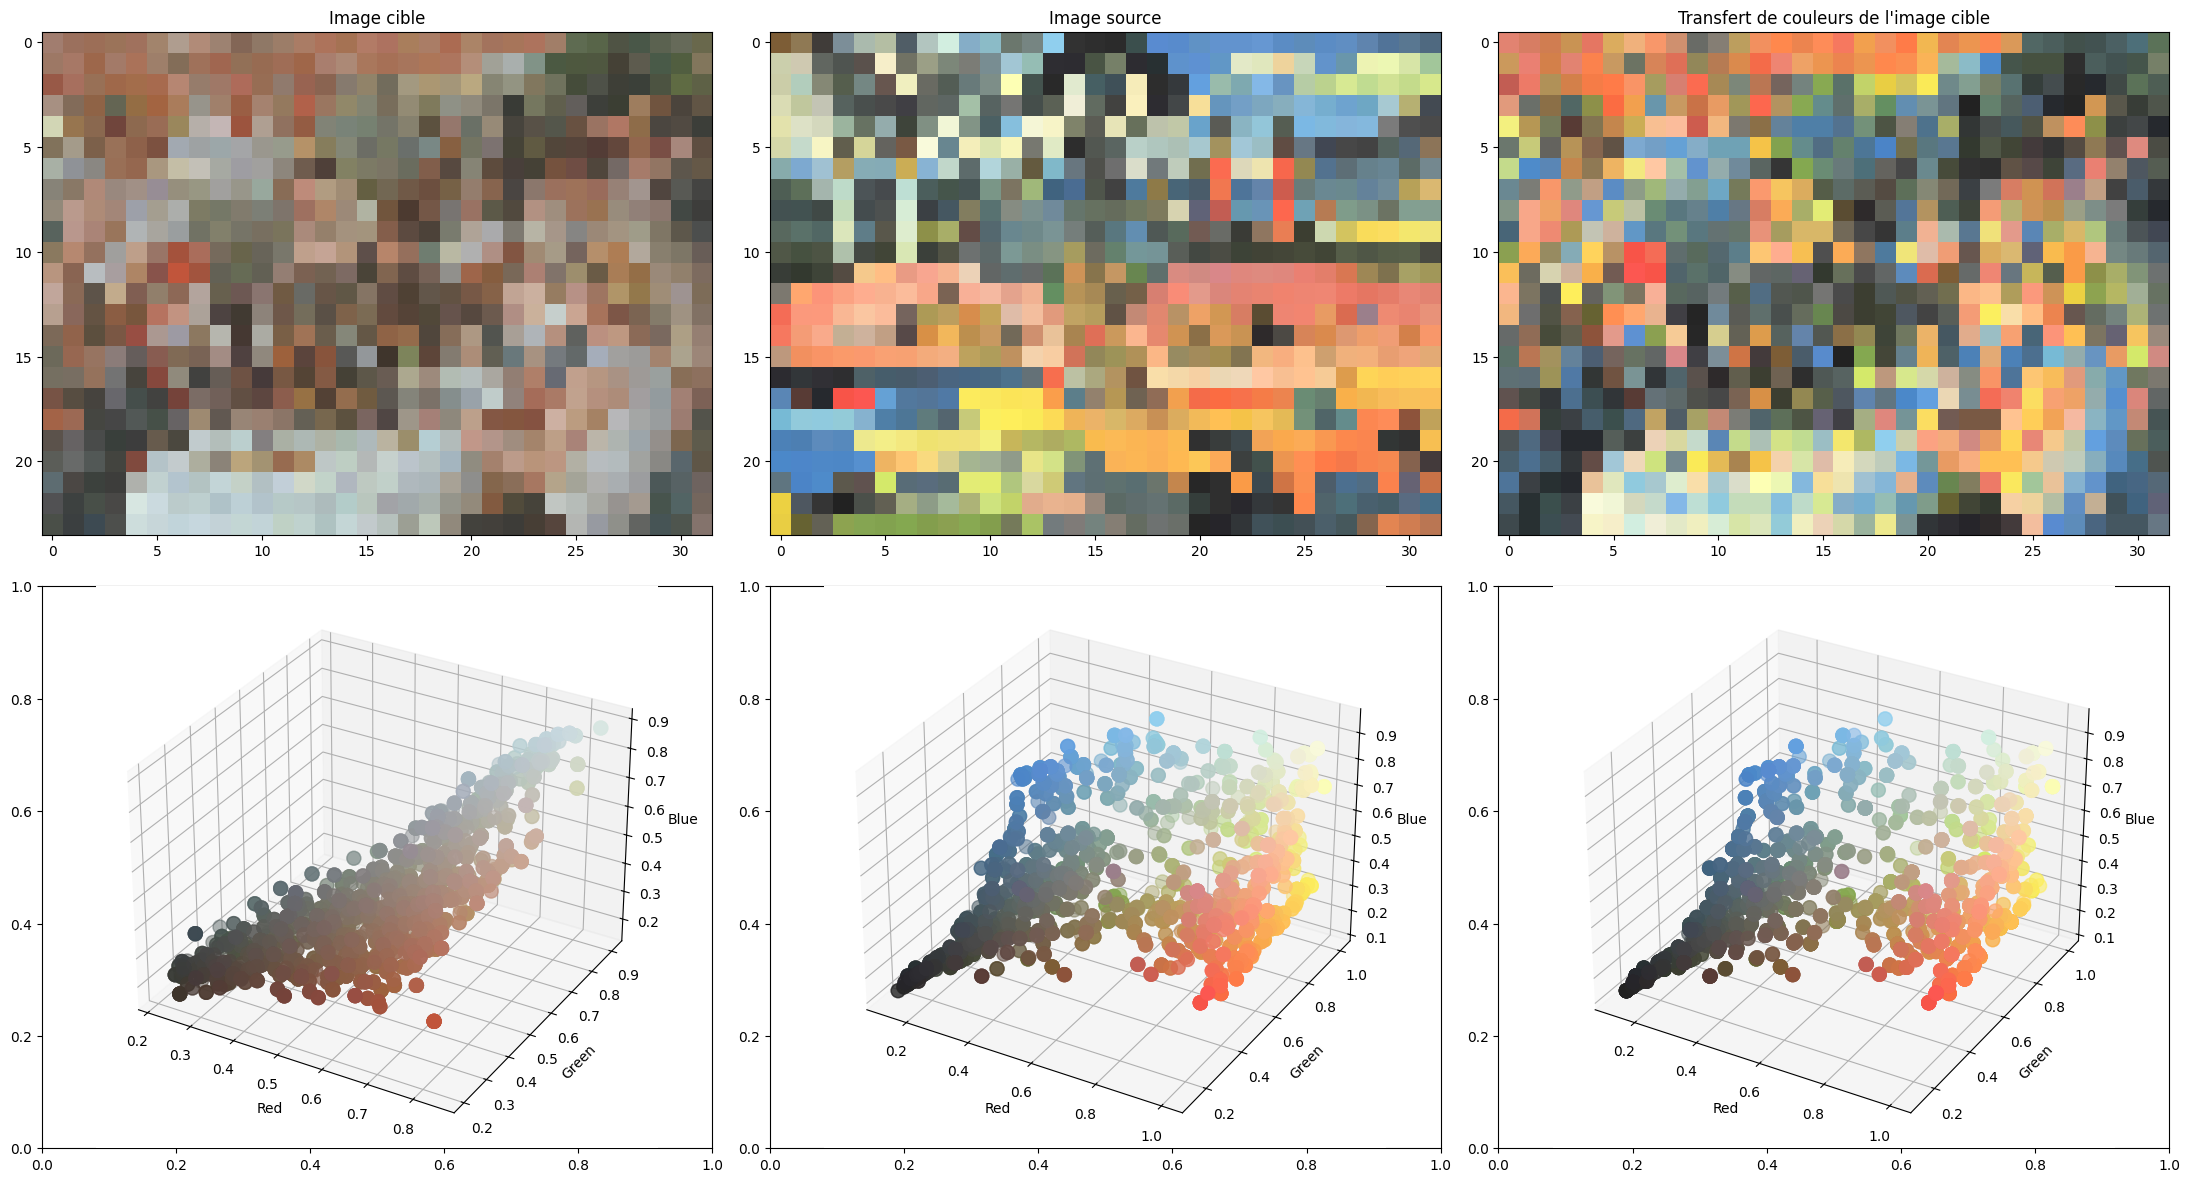

In [26]:
# Algorithme de Sinkhorn
C = cost_matrix(X, Y)
P = sinkhorn(a, b, C, 1e-3, 100)

# Choix de la couleur cible par transfert de masse maximum
Z = Y[np.argmax(P, axis=1)]

# Création de l'image par transfert de couleurs
im1_colortransfer = Z.reshape(im1_subsample.shape)

# Création d'une figure pour afficher les résultats
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# Affichage des images
axes[0][0].set_title('Image cible')
axes[0][0].imshow(im1_subsample)

axes[0][1].set_title('Image source')
axes[0][1].imshow(im2_subsample)

axes[0][2].set_title("Transfert de couleurs de l'image cible")
axes[0][2].imshow(im1_colortransfer)

# Tracé des pixels dans l'espace RVB
plot_pixel_3D(im1_subsample, fig, 4, 2, 3)  

plot_pixel_3D(im2_subsample, fig, 5, 2, 3)  

plot_pixel_3D(im1_colortransfer, fig, 6, 2, 3)

plt.tight_layout()

### **Comparaison Algorithme Stochastique vs Sinkhorn (Temps de convergence et Qualité de l'image)**

In [28]:
# Temps pour l'algorithme stochastique
start = time()
res_Algo_Sto = Algo_Sto(X, Y, a, b, c=1, rho=1/2, n_iter= 10**6, verbose=False)
end = time()
time_stochastic = end - start
print(f"Temps pour l'algorithme stochastique : {time_stochastic:.2f} secondes")

# Temps pour Sinkhorn
start = time()
P_sinkhorn = sinkhorn(a, b, C, 1e-3, 100)
end = time()
time_sinkhorn = end - start
print(f"Temps pour Sinkhorn : {time_sinkhorn:.2f} secondes")

Algorithme Stochastique: 100%|██████████| 999999/999999 [02:20<00:00, 7098.65it/s]


Temps pour l'algorithme stochastique : 140.99 secondes


Algorithme de Sinkhorn: 100%|██████████| 100/100 [00:12<00:00,  7.74it/s]

Temps pour Sinkhorn : 12.99 secondes


In [29]:
# Calcul de l'erreur de Frobenius entre les matrices
P_stochast = P_stochastic(X, Y, res_Algo_Sto[0], a, b)  # Matrice obtenue via l'algorithme stochastique
error_frobenius = np.linalg.norm(P_stochast - P_sinkhorn, ord='fro')
print(f"Erreur de Frobenius entre les deux matrices : {error_frobenius:.4f}")
print(f"Coût optimal algo_stochast {np.sum(C*P_stochast)} et Coût optimal algo_sinkhorn : {np.sum(C*P_sinkhorn)}")

P_stochastic: 100%|██████████| 768/768 [00:00<00:00, 6726.02it/s]

Erreur de Frobenius entre les deux matrices : 0.0362
Coût optimal algo_stochast 0.046674776528258376 et Coût optimal algo_sinkhorn : 0.041117550181006345


L'erreur de Frobenius entre les matrices obtenues avec l'algorithme stochastique et Sinkhorn est de 0.0360, indiquant que les deux approches produisent des résultats satisfaisants, avec une légère différence pour l'algorithme stochastique. Cela reflète sa capacité à capturer la structure du problème tout en restant une méthode d'approximation.

Cependant, le coût optimal obtenu par l'algorithme stochastique (0.0467) est légèrement supérieur à celui de Sinkhorn (0.0411). Ce qui se justifie car Sinkhorn converge vers une solution plus précise grâce à la régularisation entropique, tandis que l'algorithme stochastique atteint une solution approximative avec un compromis entre précision et rapidité computationnelle.

###  **Influence du facteur de réduction de dimension $s$ et la qualité de l'image transféré** 

Algorithme Stochastique: 100%|██████████| 999999/999999 [13:06<00:00, 1271.24it/s]


Temps pour l'algorithme stochastique : 786.82 secondes


Algorithme de Sinkhorn: 100%|██████████| 100/100 [12:46<00:00,  7.67s/it]


Temps pour Sinkhorn : 768.67 secondes


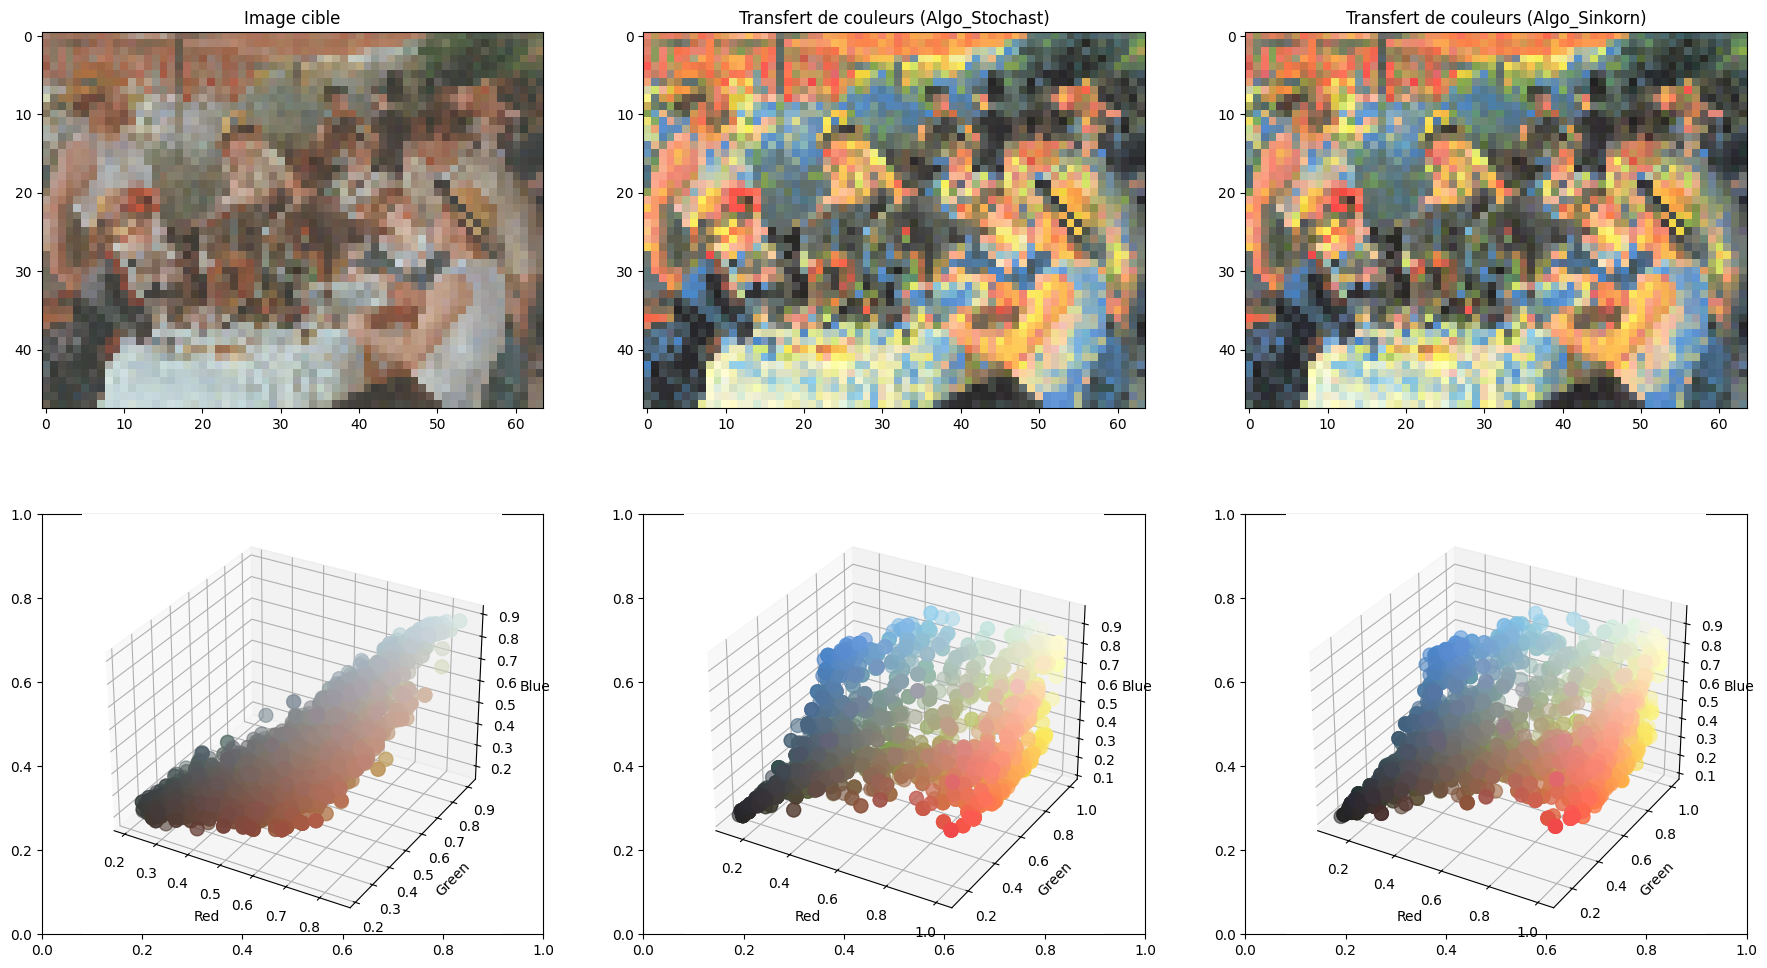

In [32]:
s = 16   # Paramètre de réduction de dimension des images

im1_subsample, im2_subsample = imrgb1[1::s,1::s,0:3], imrgb2[1::s,1::s,0:3]

X, Y = im1_subsample.reshape((im1_subsample.shape[0] * im1_subsample.shape[1], 3)), im2_subsample.reshape((im2_subsample.shape[0] * im2_subsample.shape[1], 3))

n, m = X.shape[0], Y.shape[0]

a, b = np.ones((n,)) / n, np.ones((m,)) / m 

C = cost_matrix(X, Y)

# Algorithme Stochastique
start = time()
res_Algo_Sto = Algo_Sto(X, Y, a, b, c=1, rho=1/2, n_iter= 10**6, verbose=False)
end = time()
time_stochastic = end - start
print(f"Temps pour l'algorithme stochastique : {time_stochastic:.2f} secondes")
g_last = res_Algo_Sto[0]
im1_colortrsfr_stochas = Y[np.argmax(P_stochastic(X,Y,g_last,a,b), axis=1)].reshape((im1_subsample.shape))

# Algorithme Sinkorn
start = time()
P_sinkhorn = sinkhorn(a, b, C, 0.001, 100)
end = time()
time_sinkhorn = end - start
print(f"Temps pour Sinkhorn : {time_sinkhorn:.2f} secondes")

Z = Y[np.argmax(P_sinkhorn, axis=1)]
im1_colortrsfr_sink = Z.reshape(im1_subsample.shape)

# Création d'une figure pour afficher les résultats
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# Affichage des images
axes[0][0].set_title('Image cible')
axes[0][0].imshow(im1_subsample)

axes[0][1].set_title("Transfert de couleurs (Algo_Stochast)")
axes[0][1].imshow(im1_colortrsfr_stochas)

axes[0][2].set_title("Transfert de couleurs (Algo_Sinkorn)")
axes[0][2].imshow(im1_colortrsfr_sink)

# Tracé des pixels dans l'espace RVB
plot_pixel_3D(im1_subsample, fig, 4, 2, 3)  

plot_pixel_3D(im1_colortrsfr_stochas, fig, 5, 2, 3)  

plot_pixel_3D(im1_colortrsfr_sink, fig, 6, 2, 3)

Temps pour l'algorithme stochastique : 1448.28 secondes
Temps pour Sinkhorn : 35635.11 secondes


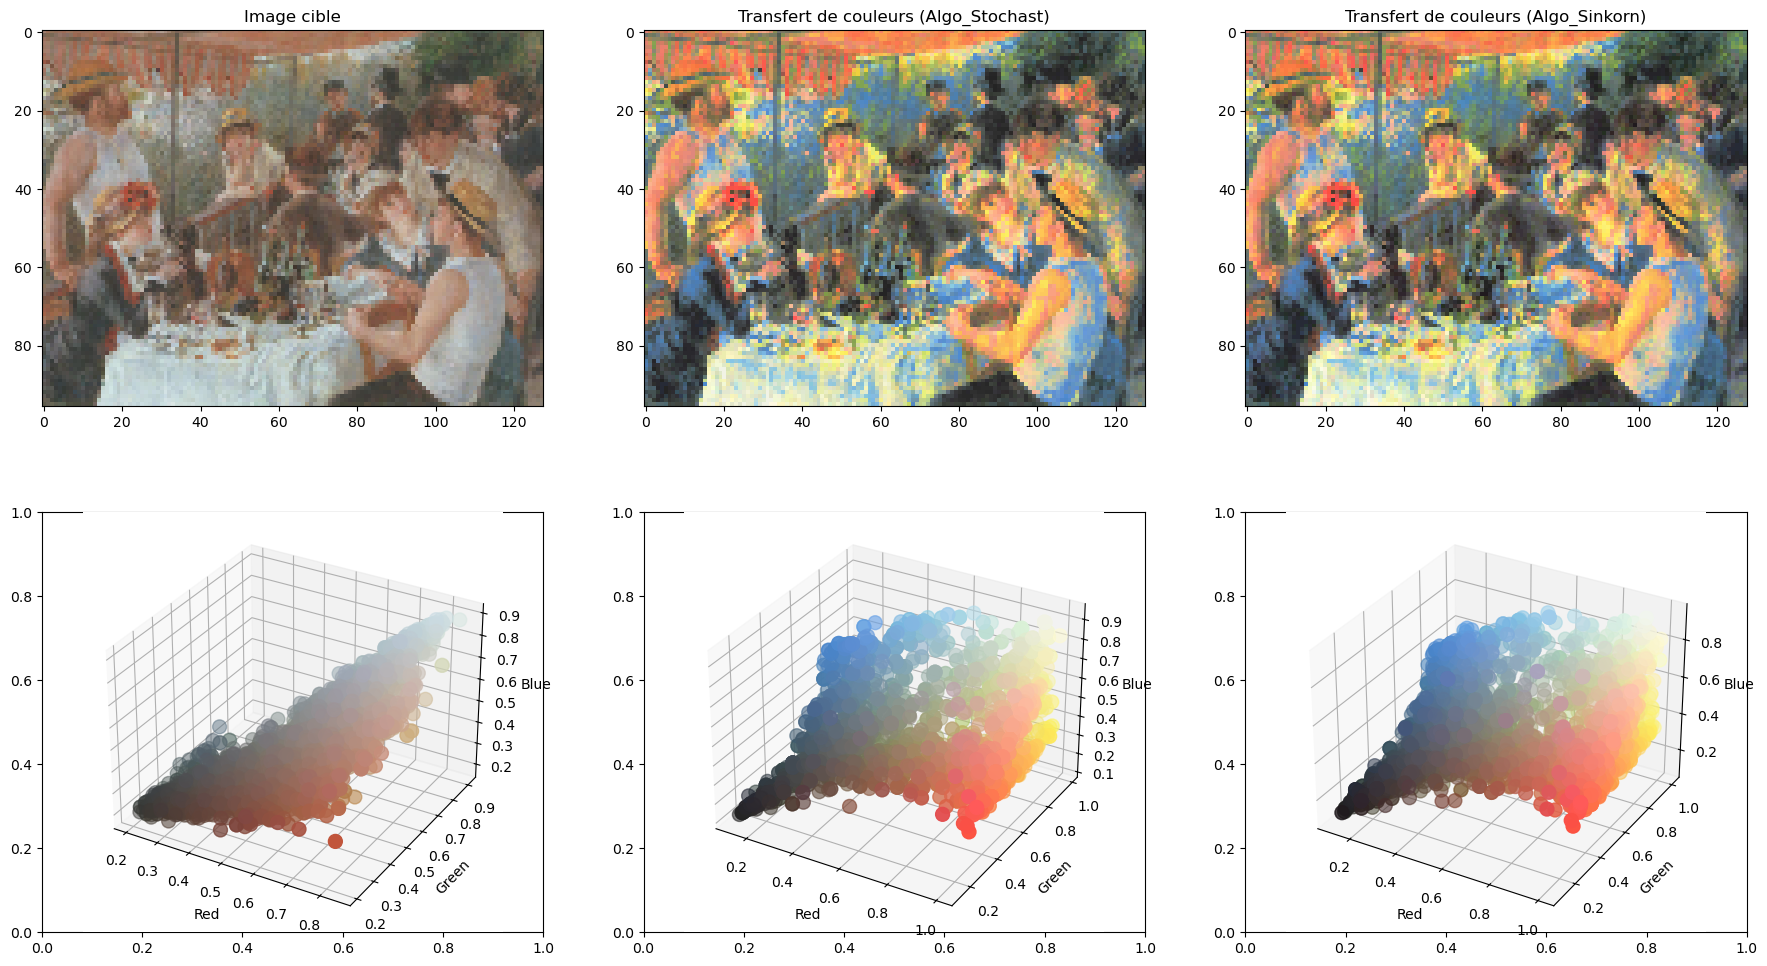

In [307]:
s = 8   # Paramètre de réduction de dimension des images

im1_subsample, im2_subsample = imrgb1[1::s,1::s,0:3], imrgb2[1::s,1::s,0:3]

X, Y = im1_subsample.reshape((im1_subsample.shape[0] * im1_subsample.shape[1], 3)), im2_subsample.reshape((im2_subsample.shape[0] * im2_subsample.shape[1], 3))

n, m = X.shape[0], Y.shape[0]

a, b = np.ones((n,)) / n, np.ones((m,)) / m 

C = cost_matrix(X, Y)

# Algorithme Stochastique
start = time()
res_Algo_Sto = Algo_Sto(X, Y, a, b, c=1, rho=1/2, n_iter= 10**6, verbose=False)
end = time()
time_stochastic = end - start
print(f"Temps pour l'algorithme stochastique : {time_stochastic:.2f} secondes")
g_last = res_Algo_Sto[0]
im1_colortrsfr_stochas = Y[np.argmax(P_stochastic(X,Y,g_last,a,b), axis=1)].reshape((im1_subsample.shape))

# Algorithme Sinkorn
start = time()
P_sinkhorn = sinkhorn(a, b, C, 0.001, 100)
end = time()
time_sinkhorn = end - start
print(f"Temps pour Sinkhorn : {time_sinkhorn:.2f} secondes")

Z = Y[np.argmax(P_sinkhorn, axis=1)]
im1_colortrsfr_sink = Z.reshape(im1_subsample.shape)

# Création d'une figure pour afficher les résultats
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# Affichage des images
axes[0][0].set_title('Image cible')
axes[0][0].imshow(im1_subsample)

axes[0][1].set_title("Transfert de couleurs (Algo_Stochast)")
axes[0][1].imshow(im1_colortrsfr_stochas)

axes[0][2].set_title("Transfert de couleurs (Algo_Sinkorn)")
axes[0][2].imshow(im1_colortrsfr_sink)

# Tracé des pixels dans l'espace RVB
plot_pixel_3D(im1_subsample, fig, 4, 2, 3)  

plot_pixel_3D(im1_colortrsfr_stochas, fig, 5, 2, 3)  

plot_pixel_3D(im1_colortrsfr_sink, fig, 6, 2, 3)

On observe que les temps de simulation de l'algorithme de Sinkhorn augmentent significativement avec la taille des données, ce qui le rend moins adapté aux problèmes de grande dimension (faibles facteurs de réduction). Par exemple, avec un facteur de réduction $s = 8$ générant un rendu final de haute qualité, Sinkhorn a nécessité environ 8 heures de calcul, contre seulement 25 minutes pour l'algorithme stochastique tout en produisant une qualité équivalente.

Cette différence s'explique par la complexité quadratique de Sinkhorn due aux opérations répétées de normalisation matricielle, tandis que l'algorithme stochastique repose sur des mises à jour locales avec une complexité linéaire, ce qui le rend bien plus adapté aux grands ensembles de données.

## Rappel sur le transport optimal uni-dimensionel

Afin de transporter la distribution complète des couleurs d'une image $u$ sur celle d'une image $v$ (en supposant les images de même taille), on écrit ces distributions sous forme de nuages de points 3D

$$X = \begin{pmatrix} X_1 \\ \vdots\\ X_n \end{pmatrix}, \;\;\text{ and }\;\; Y  = 
  \begin{pmatrix}
    Y_1 \\
\vdots\\
Y_n
  \end{pmatrix},
$$

avec $n = m$ le nombre de pixels dans $u$ et $v$, $X_i$ la couleur $(R_i,G_i,B_i)$ du $i$-ème pixel dans $u$ et $Y_i$ la couleur de le $i$-ème pixel de $v$ ($X$ et $Y$ sont des matrices $n\times 3$). On recherche la permutation $\sigma$ de $\{1,\dots, n\}$ qui minimise la quantité

$$
 \sum_{i=1}^n \|X_i - Y_{\sigma(i)}\|^2_2.
$$

La permutation optimale $\sigma$ définit une affection entre l'ensemble des couleurs $\{X_i\}_{i=1,\dots n}$ et l'ensemble des couleurs $\{Y_j\}_{j=1,\dots n}$.

### Transport in 1D

En dimension 1 (c'est à dire en supposant que $X$ et $Y$ sont des vecteurs de taille $n$), la permutation optimale $\sigma$ qui minimise le coût précédent est celle qui préserve l'ordre des points. Plus précisément, si $\sigma_X$ et $\sigma_Y$ sont les permutations telles que
$$X_{\sigma_X(1)} \leq X_{\sigma_X(2)} \leq \dots \leq X_{\sigma_X(n)},$$
$$Y_{\sigma_Y(1)} \leq Y_{\sigma_Y(2)} \leq \dots \leq Y_{\sigma_Y(n)},$$
alors $\sigma = \sigma_Y \circ \sigma_X^{-1}$ minimise le coût précédent.

La fonction suivante `transport1D` prend deux nuages ​​de points 1D $X$ et $Y$ et renvoie les permutations $\sigma_X$ et $\sigma_Y$.


In [49]:
def transport1D(X,Y):
    sx = np.argsort(X) #argsort retourne les indices des valeurs s'ils étaient ordonnés par ordre croissant   
    sy = np.argsort(Y)
    return((sx,sy)) 

Nous pouvons visualiser ce transport 1D sur des ensembles de points aléatoires. Créons d'abord deux ensembles de points en 1D

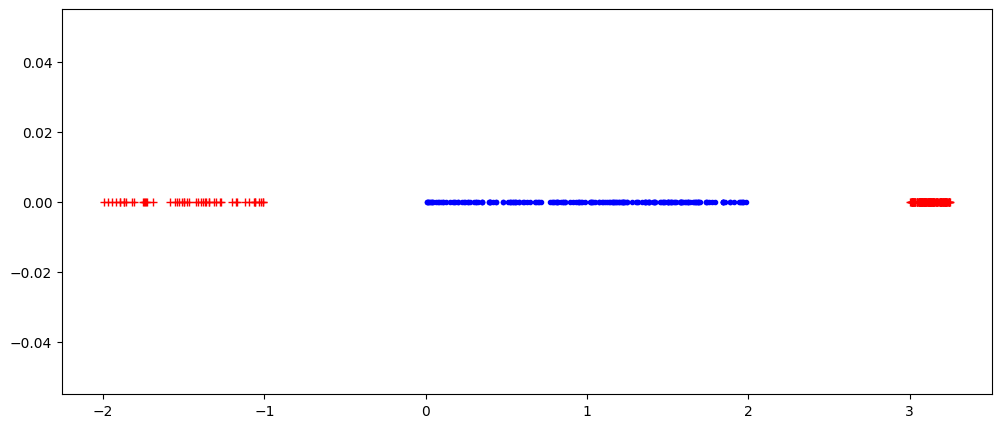

In [52]:
n = 200
X = 2 * np.random.rand(n)
Y = np.concatenate((
        np.random.rand(n//4)-2,
        .25*np.random.rand(3*n//4)+3))

plt.figure(figsize=(12, 5))
plt.plot(X,np.zeros(n),'.b')
plt.plot(Y,np.zeros(n),'+r')
plt.show()

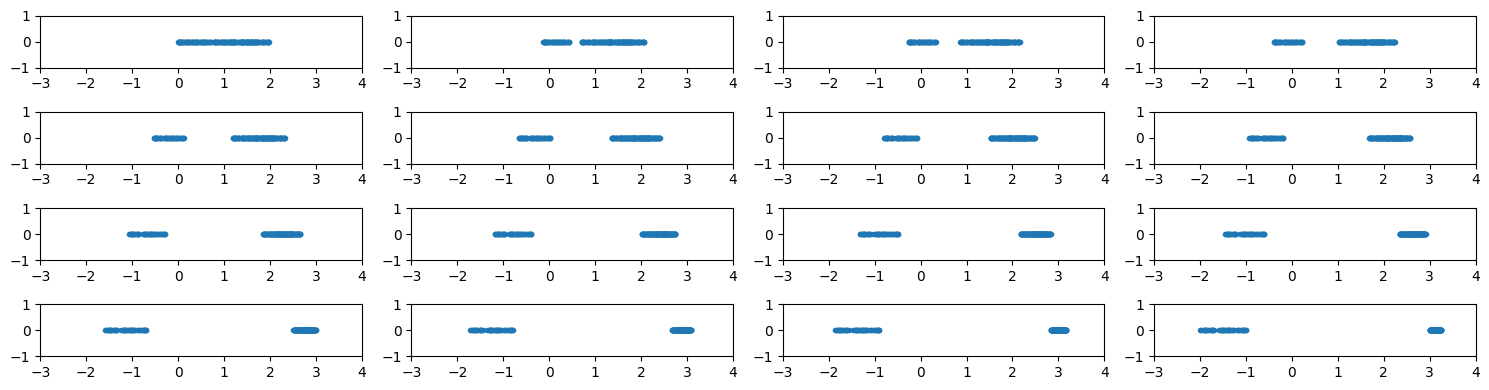

In [54]:
# Evolution de Z 

sx, sy = transport1D(X,Y)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 4))
Z = np.zeros(n)
k = 0
for i in range(4):
    for j in range(4):
        Z[sx] = X[sx] + (k/15) * (Y[sy]-X[sx])
        axes[i,j].plot(Z,np.zeros(n),'.')
        axes[i,j].axis([-3,4,-1,1])
        k += 1
fig.tight_layout()

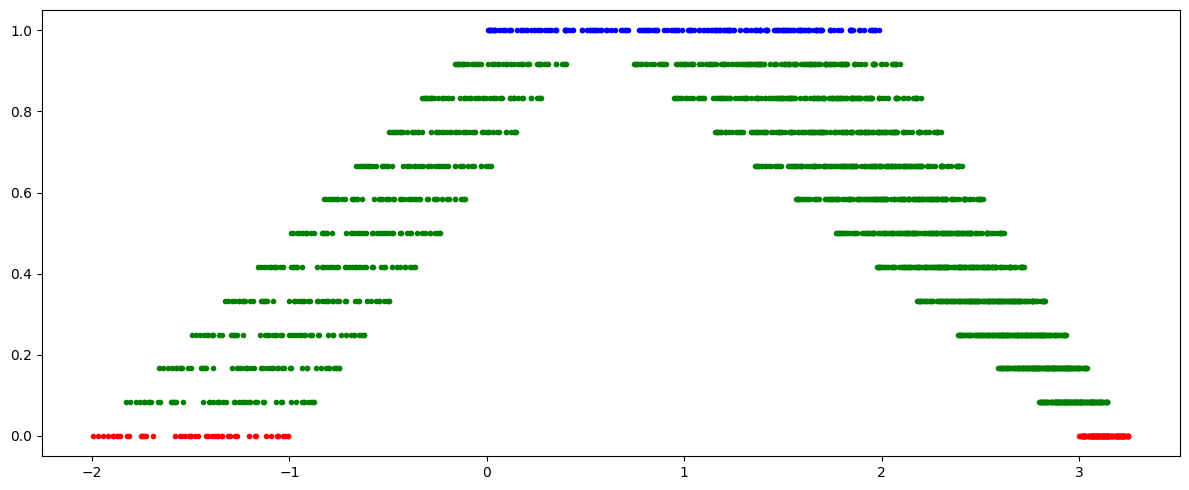

In [56]:
# Another visualization of Z from X to Y:

sx, sy = transport1D(X,Y)

Z = np.zeros(n)
k = 0

fig=plt.figure(figsize=(12, 5))
plt.plot(X,np.ones(n),'.b')
plt.plot(Y,np.zeros(n),'.r')
n_steps = 12
for k in range(1,n_steps):
    Z[sx] = X[sx] + (k/n_steps) * (Y[sy]-X[sx])
    plt.plot(Z,((n_steps-k)/n_steps)*np.ones(n),'.g')
fig.tight_layout()

###  Sliced 3D Optimal Transport

Trouver la solution du problème d’affectation dans plus d’une dimension est exigeant en termes de calcul. Au lieu de calculer la solution explicite, il est possible d'utiliser un algorithme de descente de gradient stochastique qui calcule la solution d'une approximation découpée du problème de transport optimal sur des distributions 1D à l'aide de projections aléatoires le long des itérations (voir l'article suivant (http://hal.archives-ouvertes. fr/hal-00476064/fr/)).

L'algorithme part du nuage de points $Z=X$. On rappelle que $Z$ est une matrice de taille $n \times 3$. A chaque itération, il est choisit une base orthonormée aléatoire de $\mathbb{R}^3$, notée $(u_1,u_2,u_3)$. Puis, pour $1 \leq k \leq 3$ l'algorithme progresse selon l'itération suivante
 
$$ Z_{\sigma_Z}  = Z_{\sigma_Z} + \varepsilon ( (Y,u_k)_{\sigma_Y} - (Z,u_k)_{\sigma_Z} ) u_k^T,$$

où $(\;,\;)$ est le produit scalaire dans $\mathbb{R}^3$, $\sigma_Y$ et $\sigma_Z$ sont les permutations qui ordonnent les nuages de points projetés unidimensionnels $\{(Y,u_i) := ( Y_j,u_i)\}_{j=1\dots n}$ et $\{(Z,u_i) := (Z_j,u_i)\}_{j=1\dots n}$. Cette permutation à chaque itération peut être calculée grâce à la fonction `transport1D` définie ci-dessus.  

Dans l'algorithme ci-dessus, $(Y,u_k)_{\sigma_Y}$ (resp. $(Z,u_k)_{\sigma_Z}$ ) est un vecteur de taille $n$ dont les entrées sont permutées par $\sigma_Y$ (resp. $\sigma_Z$) et $u_k^T$ est un vecteur ligne.

Après $N$ itérations  de l'algorithme, le transfert de couleur est donné par l'image $Z$ (qu'il convient de mettre en forme). 

## Travail à réaliser - Partie 2

- Vous devez écrire une fonction `transport3D(X,Y,N)` implémentant les itérations précédentes . La fonction doit prendre en entrée les nuages de points $X$ et $Y$, un nombre d'itérations $N$ de l'algorithme et de paramètre de pas  $\epsilon$. La fonction doit générer un nuage de points $Z$ et les permutations $\sigma_Z$ et $\sigma_X$.

- Indications: 
    + pour initier le nuage de points $Z$ à $X$, vous pouvez utiliser
    
            Z = np.copy(X)
    
    + pour choisir aléatoirement une base orthonormée, vous pouvez d'abord tirer un vecteur aléatoire $\mathcal{N}(0,I)$ en 3D et lui appliquer l'algorithme QR,

            u=np.random.randn(3,3)
            q=np.linalg.qr(u)[0]
            
    + le produit scalaire entre $Z$ matrice $n \times 3$ et un vecteur $u_k$ de dimension peut être calculé grâce à
            
            np.dot(Z,u_k)
           
- Vous devez enfin visualiser le transfert de couleur ainsi obtenu en tenant de prendre le facteur $s$ de réduction de dimension le plus petit possible.

### **Algorithme de transport optimal (Sliced Optimal Transport)**

In [60]:
def transport3D(X, Y, epsilon=0.01, N=100):
    """Algorithme de transport optimal en 3D (Sliced Optimal Transport) """
    n, d = X.shape
    Z = np.copy(X)
    Z_list = [np.copy(Z)]

    for _ in tqdm(range(N), desc = "Algorithm Sliced Optimal Transport"):
        # Générer une base orthonormée aléatoire
        u = np.random.randn(d, d)
        q = np.linalg.qr(u)[0]

        for u_k in q.T:
            # Calcul des projections des nuages de points
            proj_z = np.dot(Z, u_k)  # Projections de Z sur u_k
            proj_y = np.dot(Y, u_k)  # Projections de Y sur u_k

            # Calcul des permutations optimales en 1D
            sz, sy = transport1D(proj_z, proj_y)

            # Mise à jour des points de Z selon l'itération
            Z[sz] += epsilon * (proj_y[sy] - proj_z[sz]).reshape(-1, 1) * u_k
            
        # Stockage des mises à jour de Z
        Z_list.append(np.copy(Z))
    
    return np.copy(Z), Z_list

In [62]:
s = 1   # Paramètre de réduction de dimension des images

im1_subsample, im2_subsample = imrgb1[1::s,1::s,0:3], imrgb2[1::s,1::s,0:3]

X, Y = im1_subsample.reshape((im1_subsample.shape[0] * im1_subsample.shape[1], 3)), im2_subsample.reshape((im2_subsample.shape[0] * im2_subsample.shape[1], 3))

# Exécution de l'algorithme
Z_last, Z_list = transport3D(X, Y, N=1000, epsilon=1e-1)

Algorithm Sliced Optimal Transport: 100%|██████████| 1000/1000 [17:31<00:00,  1.05s/it]


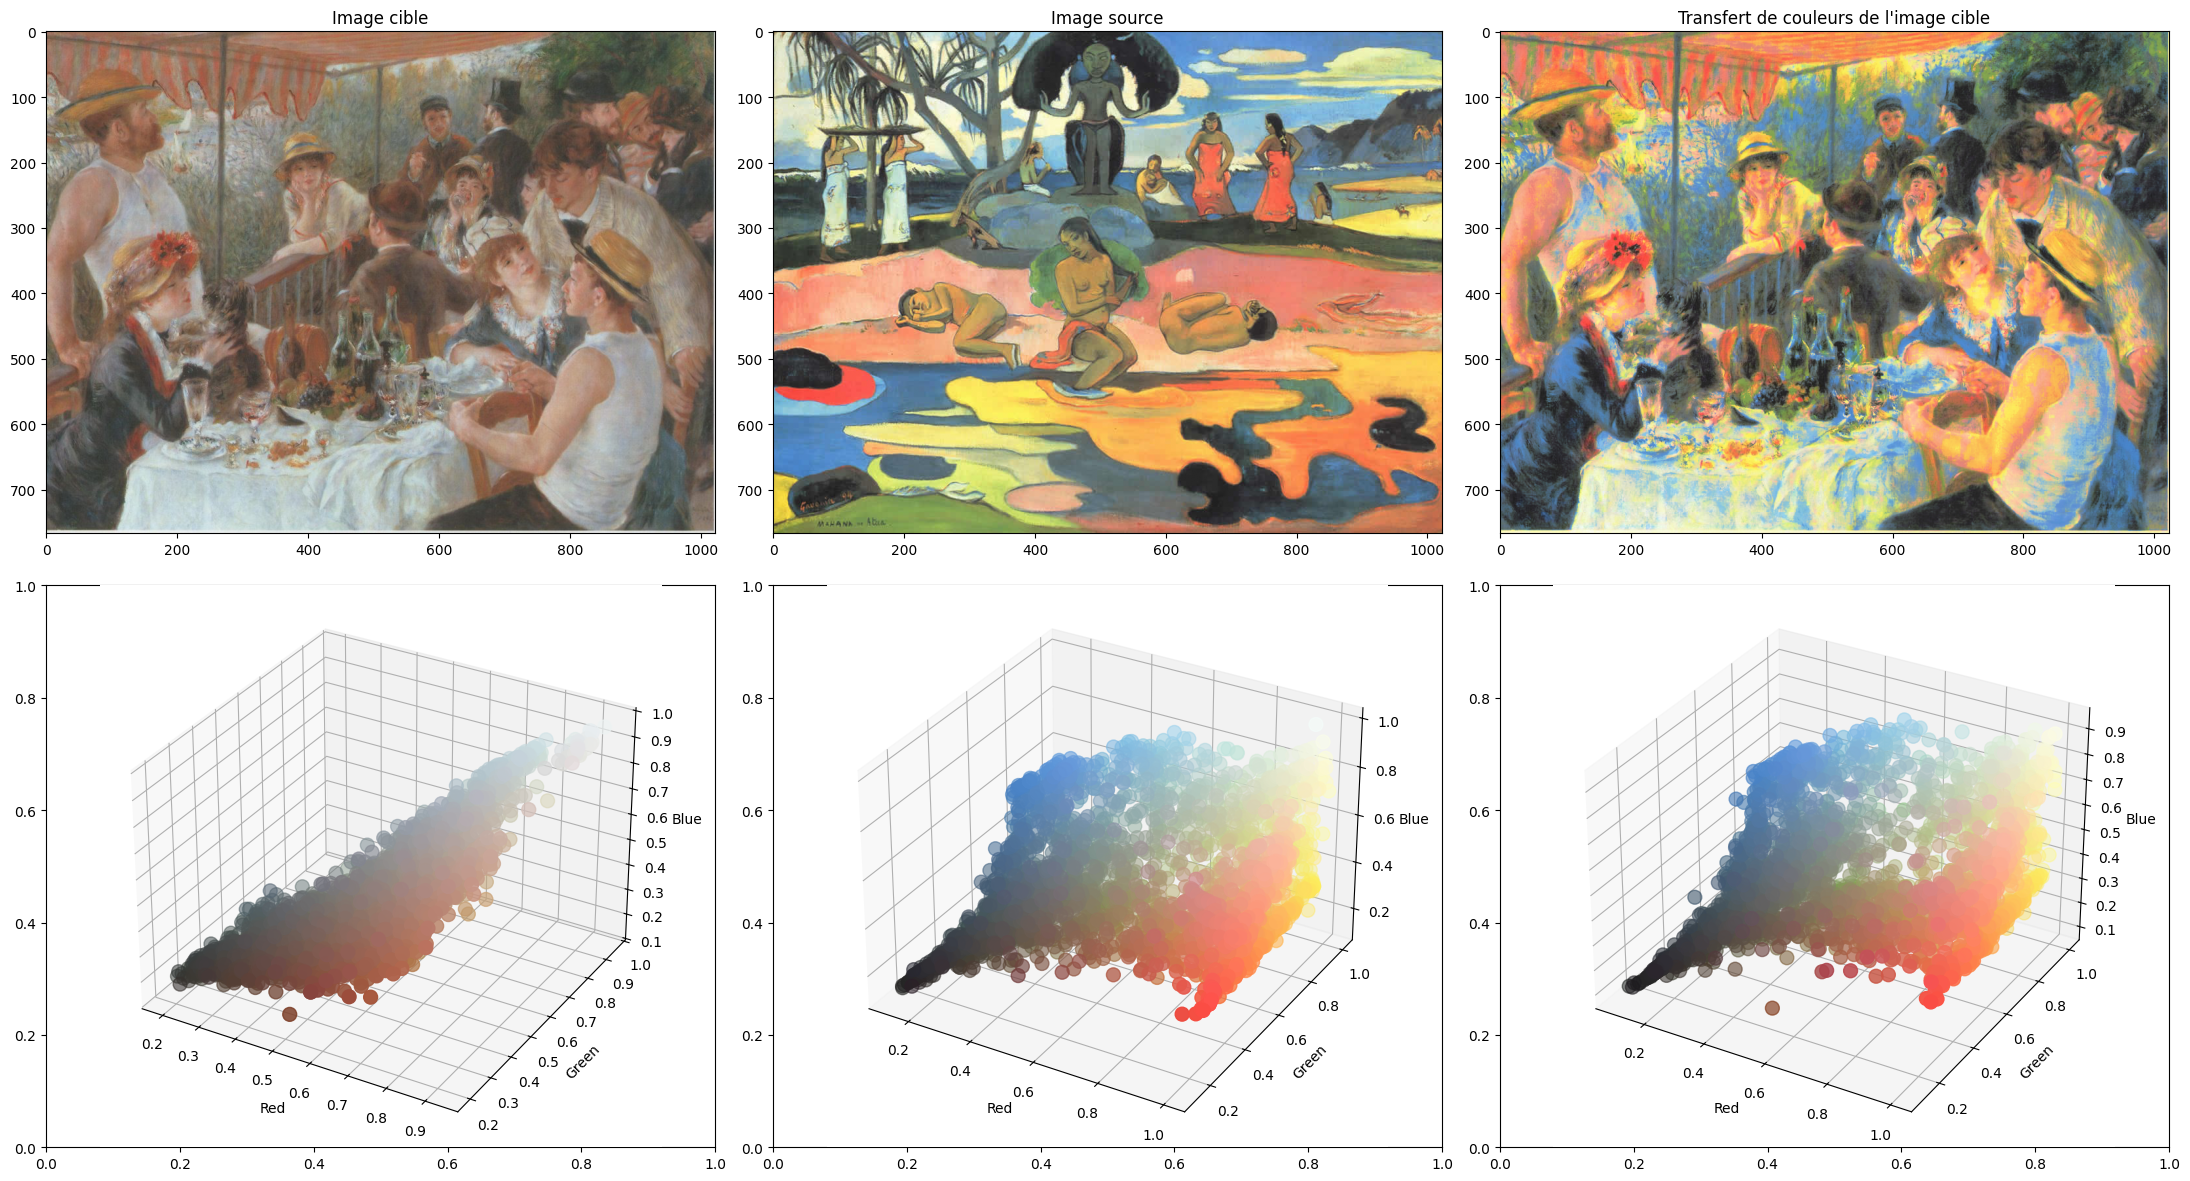

In [64]:
# Création d'une figure pour afficher les résultats
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

im_colortransfer = Z_last.reshape((im1_subsample.shape))

# Affichage des images
axes[0][0].set_title('Image cible')
axes[0][0].imshow(im1_subsample)

axes[0][1].set_title('Image source')
axes[0][1].imshow(im2_subsample)

axes[0][2].set_title("Transfert de couleurs de l'image cible")
axes[0][2].imshow((im_colortransfer*255).clip(0, 255).astype(np.uint8))

# Tracé des pixels dans l'espace RVB
plot_pixel_3D(im1_subsample, fig, 4, 2, 3)  

plot_pixel_3D(im2_subsample, fig, 5, 2, 3)  

plot_pixel_3D(im_colortransfer.clip(0, 1), fig, 6, 2, 3)

plt.tight_layout()

### **Extras : Animations (Sliced Optimal Transport)**

In [68]:
s = 8   # Paramètre de réduction de dimension des images

im1_subsample, im2_subsample = imrgb1[1::s,1::s,0:3], imrgb2[1::s,1::s,0:3]

X, Y = im1_subsample.reshape((im1_subsample.shape[0] * im1_subsample.shape[1], 3)), im2_subsample.reshape((im2_subsample.shape[0] * im2_subsample.shape[1], 3))

# Exécution de l'algorithme
Z_last, Z_list = transport3D(X, Y, N=1000, epsilon=1e-1)

Algorithm Sliced Optimal Transport: 100%|██████████| 1000/1000 [00:10<00:00, 94.26it/s]


In [70]:
# Séquençages d'images
trfs_col = []

Z_steps = Z_list[:50] + Z_list[50:-50][::10] + Z_list[-50:]

for Z in tqdm(Z_steps, desc ="Transfert de Couleurs"):
    # Visualisation des étapes
    fig = plt.figure(figsize=(18, 10), dpi=200)
    
    ## Visualiser les étapes intermédiaires
    axis = fig.add_subplot(111, projection='3d')
    
    # Sauvegarder l'image
    axis.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c='g')
    axis.set_title("Transfert de couleurs de l'image cible (Z)")
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue")
    plt.savefig('plot.png', bbox_inches="tight", pad_inches=0.8)

    # Redimensionner l'image
    image = plt.imread('plot.png')
    resized_image = resize(image, (1024, 1024))
    plt.imsave('plot_resized.png', resized_image)
    
    # Lire et sauvegarder l'image redimensionnée
    image = plt.imread('plot_resized.png')
    trfs_col.append((image * 255).clip(0, 255).astype(np.uint8))
    
    plt.close()

Transfert de Couleurs: 100%|██████████| 191/191 [11:18<00:00,  3.55s/it]


In [71]:
# Enregistrer la séquence d'images en tant que fichiers PNG
imageio.mimsave('transf_col_s8.mp4', trfs_col, fps=6)

In [76]:
# Transfert de couleurs interactifs 
dp.Video('transf_col_s8.mp4', width = 1000, height=640, html_attributes='autoplay loop')